In [4]:
import tensorflow as tf
import string
import requests
import pandas as pd

In [2]:
response = requests.get('https://raw.githubusercontent.com/laxmimerit/poetry-data/master/adele.txt')

In [5]:
filename = '/content/dataset.txt'

with open(filename, 'r') as file:
    response_text = file.read()

response = type('Response', (), {'text': response_text})

In [ ]:
# response

In [ ]:
# response.text

In [6]:
data=response.text.splitlines()
print(data[:10]) # 10 sample

['lyrics', '"puedes escuchar fernando?  ', 'me recuerda tiempo atras  ', 'estrellas y una noche alla  ', 'en la lumbre azul fernando  ', 'tarareabas tu cancion  ', 'con ese suave guitarrear  ', 'yo podia escuchar  ', 'esos tambores con un sordo redoblar  ', '  ']


In [7]:
len(data)
#there is 2400 lines in this poetry

37854

In [8]:
# Total word number is:
len(" ".join(data))

956627

In [9]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, Conv1D, MaxPooling1D
from tensorflow.keras.preprocessing.sequence import pad_sequences


#### LSTM model and train test preparation

In [10]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(data) #it's going to fit on the data in the forms of lines.

In [11]:
# help(tokenizer)

In [12]:
encoded_text=tokenizer.texts_to_sequences(data)
encoded_text[:10]
# These number actually comes from vocabulary
# it assigns number to each words

[[2662],
 [6563, 4622, 1000],
 [10, 6564, 6565, 3010],
 [6566, 600, 3011, 1519, 4623],
 [1037, 57, 6567, 6568, 1000],
 [6569, 444, 4624],
 [1330, 6570, 6571, 6572],
 [430, 6573, 4622],
 [6574, 6575, 1330, 550, 6576, 6577],
 []]

In [13]:
wc=tokenizer.word_counts
# word frequency

In [14]:
wi=tokenizer.word_index

In [15]:
print(f"Number of unique words and total vocab size: {len(tokenizer.word_counts)+1}")
vocab_size=len(tokenizer.word_counts)+1 # always adding plus one for tensorflow

Number of unique words and total vocab size: 11915


In [16]:
x=["play this song"]

In [17]:
tokenizer.texts_to_sequences(x)

[[319, 28, 138]]

### Prepare data for training

In [18]:
 encoded_text[:10] # 10 sample

[[2662],
 [6563, 4622, 1000],
 [10, 6564, 6565, 3010],
 [6566, 600, 3011, 1519, 4623],
 [1037, 57, 6567, 6568, 1000],
 [6569, 444, 4624],
 [1330, 6570, 6571, 6572],
 [430, 6573, 4622],
 [6574, 6575, 1330, 550, 6576, 6577],
 []]

In [19]:
data_list=[]
for i in encoded_text:
    if len(i)>1:
        for j in range(2,len(i)):
            data_list.append(i[:j])
#             print(i[:j]) # if you want to check data

#### Paddding

In [20]:
max_length=20
#max length of line is 20 token per line in our poetry

In [21]:
sequences=pad_sequences(data_list,maxlen=max_length,padding="pre") # we set the lenght size equal to 20
sequences[:5] # 5 sample

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0, 6563, 4622],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,   10, 6564],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,   10, 6564, 6565],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0, 6566,  600],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0, 6566,  600, 3011]],
      dtype=int32)

In [22]:
sequences.shape

(112068, 20)

In [23]:
X=sequences[:,:-1]
y=sequences[:,-1]
print("X values")
print(X[:5]) # 5 sample
print("-"*30)
print("X values")
print(y[:5]) # 5 sample

X values
[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0 6563]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0   10]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0   10 6564]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0 6566]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0 6566  600]]
------------------------------
X values
[4622 6564 6565  600 3011]


In [24]:
X.shape,y.shape

((112068, 19), (112068,))

In [25]:
y=to_categorical(y,num_classes=vocab_size)
#since unique word number is vocab_size, thus there is vocab_size classes
print(y[:5]) # 5 sample
print("Shape of y",y.shape)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Shape of y (112068, 11915)


In [26]:
print("Shape of X",X.shape)
seq_length=X.shape[1]
seq_length

Shape of X (112068, 19)


19

#### Build Model
- We will build a simple LSTM model

In [27]:
model=Sequential()
model.add(Embedding(vocab_size,50,input_length=seq_length))
#The first layer is the Embedded layer that uses 50-length vectors
#return_sequences=True because we add another LSTM
model.add(LSTM(100,return_sequences=True))
model.add(LSTM(100))
model.add(Dense(100,activation="relu"))
model.add(Dense(vocab_size,activation="softmax")) # we use softmax because there is multiclasses

In [27]:
# help(Embedding)

#### You can use dropout() , You will see that Training will be slightly slower trend in convergence, maybe lower final accuracy

In [28]:
# model=Sequential()
# model.add(Embedding(vocab_size,50,input_length=seq_length))
# #The first layer is the Embedded layer that uses 50-length vectors
# #return_sequences=True because we add another LSTM
# model.add(Dropout(0.2))
# model.add(LSTM(100,return_sequences=True))
# model.add(Dropout(0.2))
# model.add(LSTM(100))
# model.add(Dropout(0.2))
# model.add(Dense(100,activation="relu"))
# model.add(Dense(vocab_size,activation="softmax")) # we use softmax because there is multiclasses

####  Dropout can be applied to the input and recurrent connections of the memory units with the LSTM precisely and separately.
#### LSTM-specific dropout may have more pronounced effect on the convergence of the network than the layer-wise dropout.

In [29]:
# model=Sequential()
# model.add(Embedding(vocab_size,50,input_length=seq_length))
# #The first layer is the Embedded layer that uses 50-length vectors
# #return_sequences=True because we add another LSTM
# model.add(LSTM(100,return_sequences=True,dropout=0.2,recurrent_dropout=0.2))
# model.add(LSTM(100,dropout=0.2,recurrent_dropout=0.2))
# model.add(Dense(100,activation="relu"))
# model.add(Dense(vocab_size,activation="softmax")) # we use softmax because there is multiclasses

#### LSTM and CNN can be used together

In [30]:
# model=Sequential()
# model.add(Embedding(vocab_size,50,input_length=seq_length))
# #The first layer is the Embedded layer that uses 50-length vectors
# #return_sequences=True because we add another LSTM
# model.add(Conv1D(filters=32,kernel_size=3, padding="same",activation="relu"))
# model.add(MaxPooling1D(pool_size=2))
# model.add(LSTM(100,return_sequences=True))
# model.add(LSTM(100))
# model.add(Dense(100,activation="relu"))
# model.add(Dense(vocab_size,activation="softmax")) # we use softmax because there is multiclasses

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 19, 50)            595750    
                                                                 
 lstm (LSTM)                 (None, 19, 100)           60400     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 100)               10100     
                                                                 
 dense_1 (Dense)             (None, 11915)             1203415   
                                                                 
Total params: 1950065 (7.44 MB)
Trainable params: 1950065 (7.44 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [32]:
model.compile(loss="categorical_crossentropy",optimizer="adam",metrics=["accuracy"])

In [33]:
model.fit(X,y,batch_size=32,epochs=15)

Epoch 1/15
3503/3503 [==============================] - 154s 43ms/step - loss: 6.3181 - accuracy: 0.0754
Epoch 2/15
3503/3503 [==============================] - 156s 44ms/step - loss: 5.7102 - accuracy: 0.1037
Epoch 3/15
3503/3503 [==============================] - 155s 44ms/step - loss: 5.3516 - accuracy: 0.1306
Epoch 4/15
3503/3503 [==============================] - 157s 45ms/step - loss: 5.0679 - accuracy: 0.1522
Epoch 5/15
3503/3503 [==============================] - 160s 46ms/step - loss: 4.8254 - accuracy: 0.1697
Epoch 6/15
3503/3503 [==============================] - 157s 45ms/step - loss: 4.6161 - accuracy: 0.1841
Epoch 7/15
3503/3503 [==============================] - 158s 45ms/step - loss: 4.4340 - accuracy: 0.1982
Epoch 8/15
3503/3503 [==============================] - 158s 45ms/step - loss: 4.2644 - accuracy: 0.2139
Epoch 9/15
3503/3503 [==============================] - 169s 48ms/step - loss: 4.1122 - accuracy: 0.2276
Epoch 10/15
3503/3503 [==============================] 

### Text Generation

In [34]:
text_lenght= 15 # 15 words per line

def generate_text(input_text, no_lines):
    general_text=[]
    for i in range(no_lines):
        text=[]
        for _ in range(text_lenght):
            encoded=tokenizer.texts_to_sequences([input_text])
            encoded=pad_sequences(encoded,maxlen=seq_length,padding="pre")
            y_pred=np.argmax(model.predict(encoded),axis=-1) # it will generate a word index, loop up into dictionary containing word index

            predicted_word=""
            for word,index in tokenizer.word_index.items():
                if index==y_pred:
                    predicted_word=word
                    break

            input_text=input_text +' '+ predicted_word
            text.append(predicted_word)

        input_text=text[-1]
        text=" ".join(text) # input text will be the last word of first created line
        general_text.append(text)

    return general_text

In [35]:
input_text="me"
text_produced=generate_text(input_text,6)
text_produced

1/1 [==============================] - 0s 33ms/step


['than the only pleasure of the highest green end of the dark man open the',
 'ants go marching four by a blackened that i can have a dream that i',
 'will be a grand in the ride to the sky and i can have been',
 'a long like a walk in the sky and dreamless nuh together in a pear',
 'finger finger finger friends who are dear to the world and far in the world',
 'are flies on the brain in a broken wings and learn to be your arms']

In [36]:
input_text="i want to see you"
text_produced=generate_text(input_text,6)
text_produced

1/1 [==============================] - 0s 26ms/step


['i want to see you i want to see you i want to see you',
 'are the only pleasure of the highest thing to see you stirring in the highest',
 'uheh yo tila ba vienen los pajaritos que volverlo a little hih ih hih ih',
 'hih ih hih ih yitho omanqoba blah blah blah blah blah blah blah nasasaktan ih',
 'hih ih hih ih yitho omanqoba blah blah blah blah blah blah blah nasasaktan ih',
 'hih ih hih ih yitho omanqoba blah blah blah blah blah blah blah nasasaktan ih']

In [37]:
input_text="i want to see you"
text_produced=generate_text(input_text,6)
text_produced

1/1 [==============================] - 0s 27ms/step


['i want to see you i want to see you i want to see you',
 'are the only pleasure of the highest thing to see you stirring in the highest',
 'uheh yo tila ba vienen los pajaritos que volverlo a little hih ih hih ih',
 'hih ih hih ih yitho omanqoba blah blah blah blah blah blah blah nasasaktan ih',
 'hih ih hih ih yitho omanqoba blah blah blah blah blah blah blah nasasaktan ih',
 'hih ih hih ih yitho omanqoba blah blah blah blah blah blah blah nasasaktan ih']

In [38]:
input_text="i have tried in vain"
text_produced=generate_text(input_text,6)
text_produced

1/1 [==============================] - 0s 29ms/step


['abide with a long and the ants go marching four by a blackened that i',
 'will be a grand in the ride to the sky and i can have been',
 'a long like a walk in the sky and dreamless nuh together in a pear',
 'finger finger finger friends who are dear to the world and far in the world',
 'are flies on the brain in a broken wings and learn to be your arms',
 'the stairs into the sky the universe will be a reason to be your own']

In [39]:
training_loss = [
    6.3181, 5.7102, 5.3516, 5.0679, 4.8254,
    4.6161, 4.4340, 4.2644, 4.1122, 3.9726,
    3.8460, 3.7260, 3.6128, 3.5075, 3.4101
]

training_accuracy = [
    0.0754, 0.1037, 0.1306, 0.1522, 0.1697,
    0.1841, 0.1982, 0.2139, 0.2276, 0.2416,
    0.2560, 0.2702, 0.2833, 0.2971, 0.3100
]

epochs = range(1, 16)  # 15 epochs


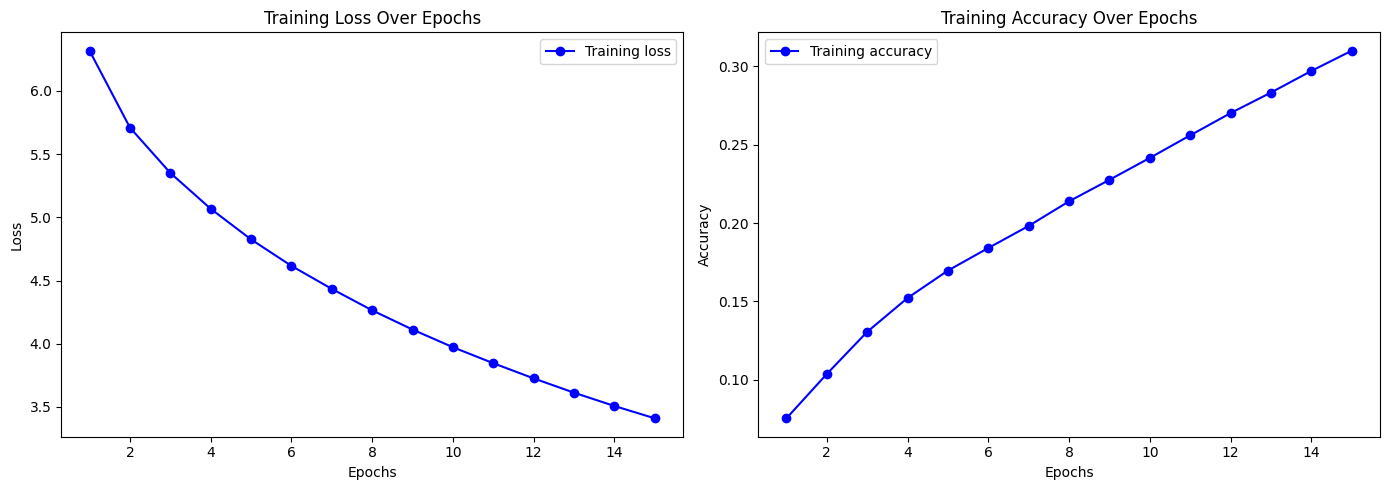

In [40]:
import matplotlib.pyplot as plt

# Plot Training Loss
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, training_loss, 'bo-', label='Training loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Training Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, training_accuracy, 'bo-', label='Training accuracy')
plt.title('Training Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
